In [1]:
#Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import re
import datetime
from scipy import interpolate
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
#Define constant values
area = 6000 #Building area
bldg_id = '42-000' #Specify the building ID

In [3]:
#Specify current directory and input/output paths
path = os.getcwd()
cmms_input_path = path + r'\sample data\cmms' #Specify directory for CMMS data
zone_input_path = path + r'\sample data\hvac\zone' #Specify directory for zone-level HVAC data
weather_input_path = path + r'\sample data\weather' #Specify directory for weather data
output_path = path + r'\output' #Specify output directory for KPIs and visualizations

In [4]:
#Read CMMS data file
cmms_files = os.listdir(cmms_input_path)
cmms_files_csv = [f for f in cmms_files if f[-3:] == 'csv']
cmms = pd.read_csv(cmms_input_path + '\\' + cmms_files_csv[0],encoding='unicode escape')

#Read zone-level HVAC data files
zone_files = os.listdir(zone_input_path)
zone_files_csv = [f for f in zone_files if f[-3:] == 'csv']
zone = pd.DataFrame()
for f in zone_files_csv:
    data = pd.read_csv(zone_input_path + '\\' + f, usecols=[1,2,3,4])
    if len(data) > 8760:
        data.drop(data.tail(len(data)-8760).index,inplace=True)
    zone = pd.concat([zone,data],axis=1)

#Read AMY weather data
weather_files = os.listdir(weather_input_path)
weather_files_csv = [f for f in weather_files if f[-3:] == 'csv']
weather = pd.read_csv(weather_input_path + '\\' + weather_files_csv[0],usecols=[3],skiprows=18)
tOa = weather[weather.columns[0]]
time_tOa = pd.date_range(start="2019-01-01",end="2019-12-31 23:00:00" ,freq='h')

#Extract timestamp column of the first zone data file
zone_time = pd.read_csv(zone_input_path + '\\' + zone_files_csv[0],usecols=[0])
zone_time[zone_time.columns[0]] = pd.to_datetime(zone_time[zone_time.columns[0]])

In [5]:
cols_to_use = ['Operator comments', 'Building ID', 'Report Time']
mask = (cmms['Building ID'] == bldg_id)
cmms_data = cmms.loc[mask, cols_to_use]
cmms_time =cmms_data['Report Time']
cmms_time = pd.to_datetime(cmms_time)

In [6]:
hotComplain = cmms_data[cmms_data['Operator comments'].str.contains("hot", "water")]
hotComplainTime = pd.to_datetime(hotComplain['Report Time'])

In [7]:
coldComplain = cmms_data[cmms_data['Operator comments'].str.contains("cold","water")]
coldComplainTime = pd.to_datetime(coldComplain['Report Time'])

In [8]:
if len(zone) != 0:
    startTime = max(time_tOa.min(),zone_time['Unnamed: 0'].min(),cmms_time.min())
    stopTime = min(time_tOa.max(),cmms_time.max(),zone_time['Unnamed: 0'].max())
else:
      startTime = max(time_tOa.min(),cmms_time.min())
      stopTime = min(time_tOa.max(),cmms_time.max())
time = pd.date_range(start=startTime,end=stopTime,freq='h')

In [9]:
data = pd.DataFrame()
data['Report Time'] = time
data['tOa'] = tOa

In [10]:
if len(zone)!=0:
  handle = zone_time

In [11]:
zone_tIn = zone.filter(like='tIn').mean(axis=1)
data['zone_tIn_mean'] = zone_tIn

In [12]:
cmms_data['coldComplain'] =cmms_data['Operator comments'].str.contains("cold",case=False).fillna(0).astype(int)
cmms_data['hotComplain'] = cmms_data['Operator comments'].str.contains("hot",case=False).fillna(0).astype(int)

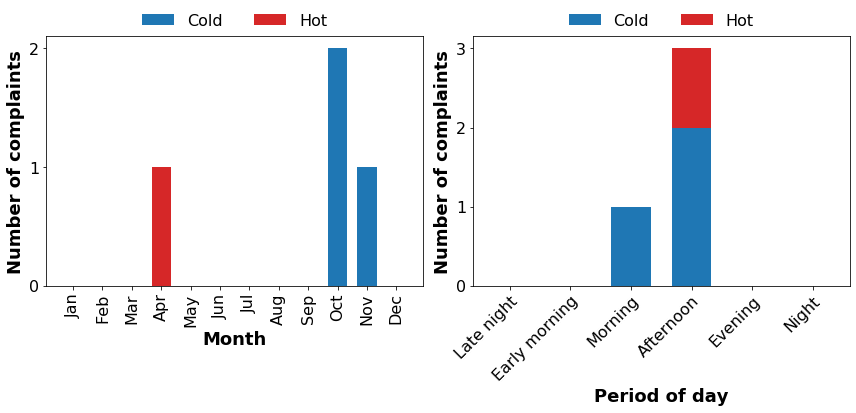

In [13]:
fig = plt.figure(figsize=(12, 6)).gca()

#Sort complaints by month
ax = plt.subplot(1,2,1)
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
cmms_data['Report Time'] = pd.to_datetime(cmms_data['Report Time'], dayfirst=True)
monthly_cold_complaints = cmms_data.groupby([cmms_data['Report Time'].dt.month_name()], sort=False).sum().eval('coldComplain')
monthly_hot_complaints = cmms_data.groupby([cmms_data['Report Time'].dt.month_name()], sort=False).sum().eval('hotComplain')

ax.bar(months,monthly_cold_complaints,width=0.65,color='tab:blue',bottom=monthly_hot_complaints)
ax.bar(months,monthly_hot_complaints,width=0.65,color='tab:red')

ax.set_ylabel('Number of complaints',fontsize=18,fontweight='bold')
ax.set_xlabel('Month',fontsize=18,fontweight='bold')
plt.yticks(fontsize=16)
ax.legend(['Cold', 'Hot'],loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.15), ncol=2, prop={"size":16})
ax.set_xticklabels(months, rotation=90, fontsize=16)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#Sort complaints by time of day
ax = plt.subplot(1,2,2)
cmms_data['period'] = (cmms_data['Report Time'].dt.hour % 24 + 4) // 4
cmms_data['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

#Count number of cold complaints per period
period_cold_complaints = []
i=0
for period in ['Late Night','Early Morning','Morning','Noon','Evening','Night']:
  period_cold_complaints.append(((cmms_data['coldComplain']==1)&(cmms_data['period']==period)).sum())
  i=+1

#Count number of hot complaints per period
period_hot_complaints = []
i=0
for period in ['Late Night','Early Morning','Morning','Noon','Evening','Night']:
  period_hot_complaints.append(((cmms_data['hotComplain']==1)&(cmms_data['period']==period)).sum())
  i=+1

ax = plt.subplot(1,2,2)
periods = ['Late night','Early morning','Morning','Afternoon','Evening','Night']
p1 = ax.bar(periods,period_cold_complaints,width=0.65,color='tab:blue')
p2 = ax.bar(periods,period_hot_complaints,width=0.65,bottom=period_cold_complaints,color='tab:red')

ax.set_ylabel('Number of complaints',fontsize=18, fontweight='bold')
ax.set_xlabel('Period of day',fontsize=18,fontweight='bold')
ax.legend(['Cold', 'Hot'],loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.15), ncol=2, prop={"size":16})
ax.set_xticklabels(periods, fontsize=16)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha="right",rotation_mode="anchor")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(output_path + r'\complaints_breakdown.png',dpi=600)

In [14]:
#Merge CMMS data with tOa and zone temp data
cmms_data = pd.concat([cmms_data, data], ignore_index = True)
cmms_data.sort_values(by='Report Time', inplace = True)

In [15]:
#Interpolate any Nan values
cmms_data[['tOa','zone_tIn_mean']] = cmms_data[['tOa','zone_tIn_mean']].interpolate(method='linear', limit_direction='forward', axis=0)
cmms_data = cmms_data.dropna(how='any')

In [16]:
#Take only cold and hot complaints
coldComplain_grouped = cmms_data.loc[cmms_data['coldComplain'] == 1]
hotComplain_grouped = cmms_data.loc[cmms_data['hotComplain'] == 1]

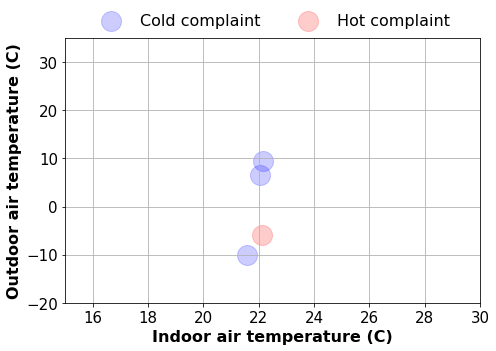

In [17]:
#Plot complaints in relation to zone/outdoor air temp.
fig = plt.figure(figsize=(7, 5))
plt.scatter(x=coldComplain_grouped['zone_tIn_mean'],y=coldComplain_grouped['tOa'],c='blue',marker='o',s= [20**2],alpha=0.2)
plt.scatter(x=hotComplain_grouped['zone_tIn_mean'],y=hotComplain_grouped['tOa'],c='red',marker='o',s=20**2,alpha=0.2)
plt.xlabel('Indoor air temperature (C)',fontsize=16,fontweight='bold')
plt.ylabel('Outdoor air temperature (C)',fontsize=16,fontweight='bold')
plt.xlim(15,30)
plt.ylim(-20,35)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(['Cold complaint','Hot complaint'],loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, prop={"size":16},frameon=False)
plt.tight_layout()
plt.savefig(output_path + r'\complaint_scatter.png',dpi=600)

In [18]:
cmms_data['dayOfWeek'] =pd.to_datetime(cmms_data['Report Time']).dt.dayofweek
cmms_data['hourOfDay'] =pd.to_datetime(cmms_data['Report Time']).dt.hour

In [19]:
cmms_data['dayofweek_name'] = pd.to_datetime(cmms_data['Report Time']).dt.day_name()
cmms_data['is_weekend'] = np.where(cmms_data['dayofweek_name'].isin(['Sunday','Saturday']),1,0)

In [20]:
le = preprocessing.LabelEncoder()
le.fit(cmms_data['period'])
cmms_data['period'] =le.transform(cmms_data['period'])

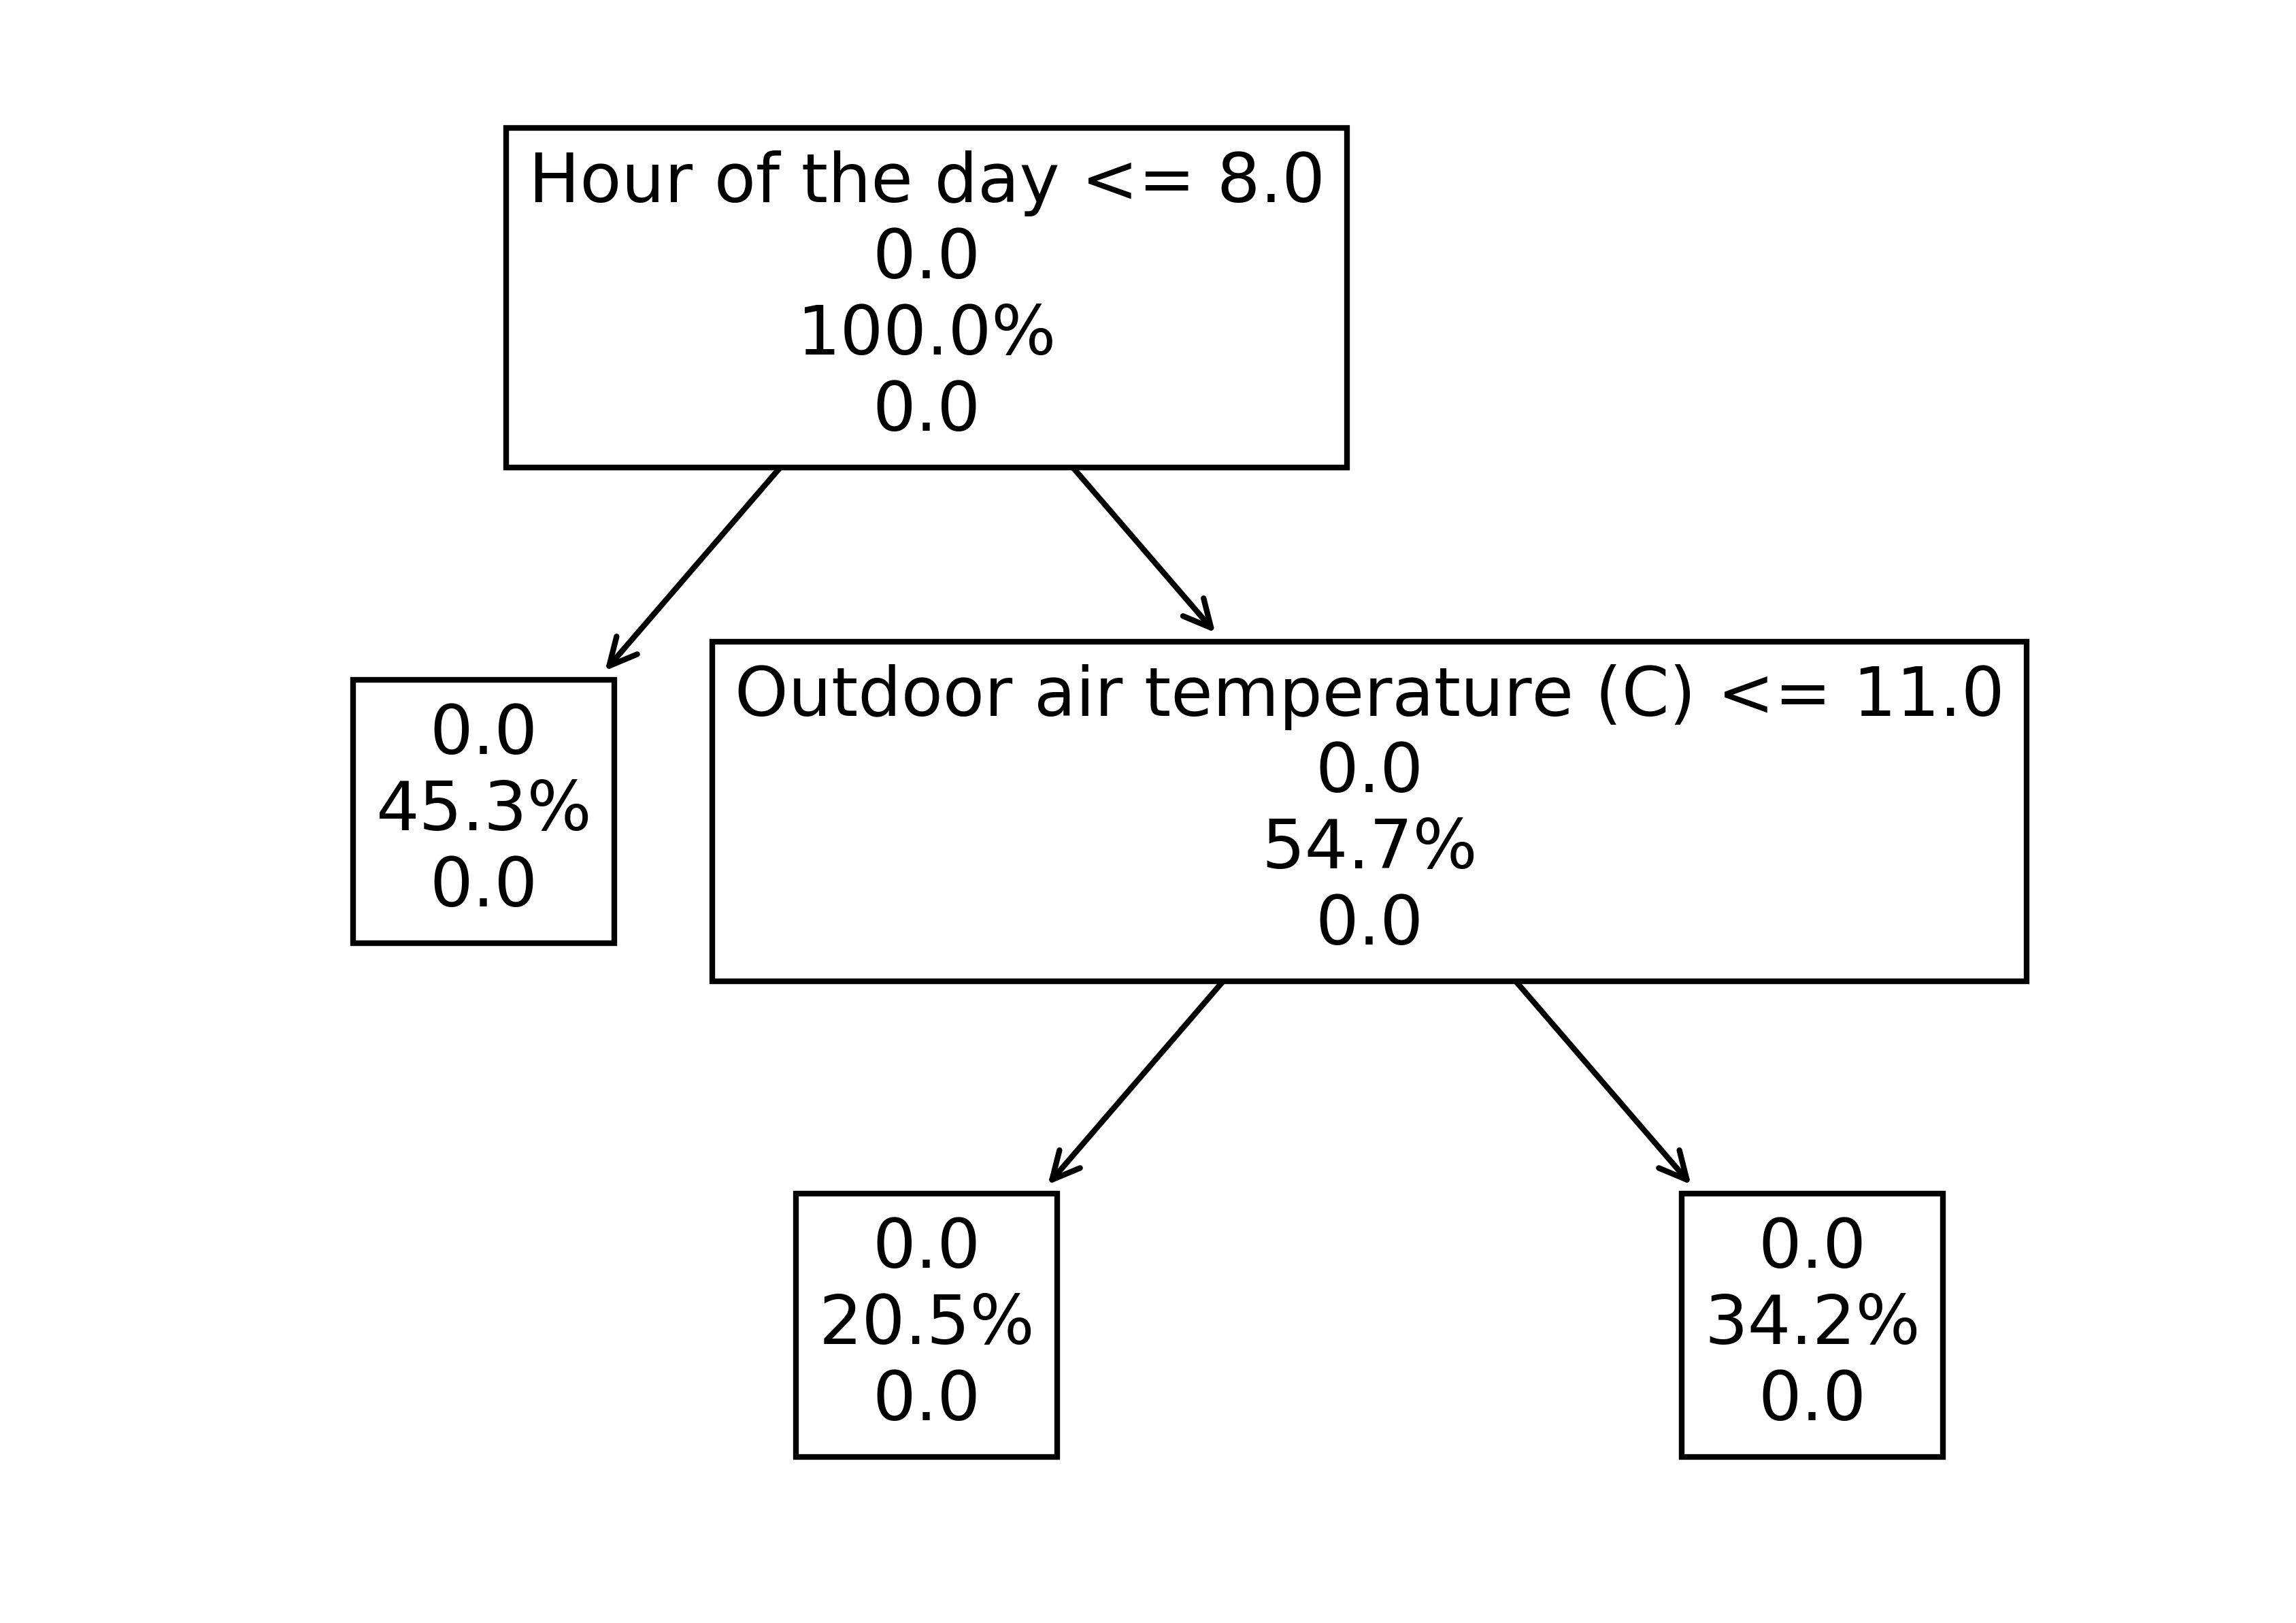

<Figure size 432x288 with 0 Axes>

In [21]:
X = cmms_data[['hourOfDay','dayOfWeek','tOa']]
y = cmms_data['coldComplain']+cmms_data['hotComplain']

reg = DecisionTreeRegressor(max_leaf_nodes=3,random_state=0,splitter='random')
reg.fit(X, y)

fn=['Hour of the day','Day of the week','Outdoor air temperature (C)']
fig, ax = plt.subplots(figsize = (7,5), dpi=600)
tree.plot_tree(reg,feature_names = fn,filled = False, label='none',impurity='False',proportion=True,precision=0,fontsize=12)

#plt.scatter(X['hour of day'], reg.predict(X), color = 'blue')
#plt.xlabel('Outdoor air temperature (C)')
#plt.ylabel('Frequency of Complaints')
plt.show()

plt.tight_layout()
fig.savefig(output_path + r'\decision_tree.png',dpi=600)


In [22]:
#Calculate KPIs
cmms_data['month'] = pd.to_datetime(cmms_data['Report Time']).dt.month
c = cmms_data[['hotComplain']].where((cmms_data['month'] < 5) | (cmms_data['month']> 9)).sum()
b=cmms_data[['month']].where((cmms_data['month'] < 5) | (cmms_data['month']> 9)).sum()
a = ((b *5/7/24)*area/1000)
kpi_freqHot_winter = float(c)/float(a)

d= cmms_data[['hotComplain']].where((cmms_data['month'] >= 5) & (cmms_data['month'] <= 9)).sum()
kpi_freqHot_summer = float(d)/float(a)

e = cmms_data[['coldComplain']].where((cmms_data['month'] < 5) | (cmms_data['month']> 9)).sum()
kpi_freqCold_winter = float(e)/float(a)

f= cmms_data[['coldComplain']].where((cmms_data['month'] >= 5) & (cmms_data['month'] <= 9)).sum()
kpi_freqCold_summer = float(f) / float(a)

#Output an excel table with KPIs
d = {'Type of complaint': ['Hot complaint', 'Cold complaint'],
     'Winter': [kpi_freqHot_winter,kpi_freqCold_winter],
     'Summer':[kpi_freqHot_summer,kpi_freqCold_summer]}
kpi_df = pd.DataFrame(data=d)

writer = pd.ExcelWriter(output_path + r'\complaints_freq.xlsx', engine='xlsxwriter')
kpi_df.to_excel(writer, sheet_name='Daily frequency of complaints')
writer.save()
